# Create a master dataframe with all _C. elegans_ datasets for plotting with `seaborn`.
Create a file `worm_data_xxxx.csv` that aggregates worm data from all datasets.

In [1]:
import torch
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import HTML
from data._utils import load_dataset
from mpl_toolkits.mplot3d import Axes3D
from utils import VALID_DATASETS, NEURONS_302
from matplotlib.animation import FuncAnimation

In [ ]:
# Custom function to check if all values in a list are 0.0
def all_zeros(lst):
    return all(val == 0.0 for val in lst)


all_worm_datasets = [
    load_dataset(dataset)
    for dataset in sorted(VALID_DATASETS, key=lambda x: x[-4:])
    if not dataset.__contains__("sine")
]

new_dict = dict()

for dataset in all_worm_datasets:
    for worm in dataset:
        for neuron, slot in dataset[worm]["neuron_to_slot"].items():
            # get data to fill in table
            dataset_name = dataset[worm]["dataset"]
            smooth_method = dataset[worm]["smooth_method"]
            calcium_data = dataset[worm]["calcium_data"][:, slot].numpy()
            # ignore neurons with no calcium data
            if all_zeros(calcium_data):
                continue
            smooth_calcium_data = dataset[worm]["smooth_calcium_data"][:, slot].numpy()
            residual_calcium = dataset[worm]["residual_calcium"][:, slot].numpy()
            smooth_residual_calcium = dataset[worm]["smooth_residual_calcium"][
                :, slot
            ].numpy()
            time_in_seconds = dataset[worm]["time_in_seconds"].squeeze().numpy()
            dt = dataset[worm]["dt"].squeeze().numpy()
            max_timesteps = dataset[worm]["max_timesteps"]
            if neuron in dataset[worm]["named_neuron_to_slot"]:
                is_named_neuron = True
                is_unknown_neuron = False
            elif neuron in dataset[worm]["unknown_neuron_to_slot"]:
                is_named_neuron = False
                is_unknown_neuron = True
            else:
                print("Neither named nor unknown neuron?!?!?!")

            # fill in table
            new_dict.setdefault("dataset", new_dict.get("dataset", [])).append(
                dataset_name
            )
            new_dict.setdefault("worm", new_dict.get("worm", [])).append(worm)
            new_dict.setdefault("neuron", new_dict.get("neuron", [])).append(neuron)
            new_dict.setdefault("slot", new_dict.get("slot", [])).append(slot)
            new_dict.setdefault(
                "is_named_neuron", new_dict.get("is_named_neuron", [])
            ).append(is_named_neuron)
            new_dict.setdefault(
                "is_unknown_neuron", new_dict.get("is_unknown_neuron", [])
            ).append(is_unknown_neuron)
            new_dict.setdefault(
                "calcium_data", new_dict.get("calcium_data", [])
            ).append(calcium_data)
            new_dict.setdefault(
                "smooth_calcium_data", new_dict.get("smooth_calcium_data", [])
            ).append(smooth_calcium_data)
            new_dict.setdefault(
                "residual_calcium", new_dict.get("residual_calcium", [])
            ).append(residual_calcium)
            new_dict.setdefault(
                "smooth_residual_calcium", new_dict.get("smooth_residual_calcium", [])
            ).append(smooth_residual_calcium)
            new_dict.setdefault(
                "smooth_method", new_dict.get("smooth_method", [])
            ).append(smooth_method)
            new_dict.setdefault(
                "time_in_seconds", new_dict.get("time_in_seconds", [])
            ).append(time_in_seconds)
            new_dict.setdefault("dt", new_dict.get("dt", [])).append(dt)
            new_dict.setdefault(
                "max_timesteps", new_dict.get("max_timesteps", [])
            ).append(max_timesteps)

df_short = pd.DataFrame.from_dict(new_dict)

# Save to a CSV file
pd.DataFrame.to_csv(df_short, "../data/worm_data_short.csv")

# Display the dataframe
df_short

This DataFrame `df_short` seems to contain information on neuronal calcium activity of a worm dataset. The columns are as follows:
1. `dataset`: The dataset identifier, in this case "Kato2015".
2. `worm` : Worm identifier, e.g. "worm0".
3. `neuron`: Neuron identifier, either a named neuron like "ADAL" or an integer index for unnamed neurons.
4. `slot`: An integer index representing the position of the neuron in the dataset.
5. `is_named_neuron`: A boolean indicating if the neuron has a specific name (True) or is indexed by an integer (False).
6. `is_unknown_neuron`: A boolean indicating if the neuron is unknown (True) or not (False).
7. `calcium_data`: A list of raw calcium activity values for the neuron.
8. `smooth_calcium_data`: A list of smoothed calcium activity values for the neuron.
9. `residual_calcium`: A list of residual calcium values for the neuron.
10. `smooth_residual_calcium`: A list of smoothed residual calcium values for the neuron.
11. `smooth_method`: The method used for smoothing the calcium data, in this case, "FFT" (Fast Fourier Transform).
12. `time_in_seconds`: A list of time points in seconds corresponding to the calcium data.
13. `dt`: A list of time differences between consecutive time points in seconds.
14. `max_timesteps`: The maximum number of timesteps for the calcium data, in this case, 2198.

Yes, you can restructure your DataFrame to make it more suitable for visualization using seaborn. One common format that seaborn works well with is the "long format" or "tidy format". In this format, each row represents a single observation, and each column represents a variable.

Here's a suggestion on how to restructure your DataFrame:

1. Create a new DataFrame with only the columns you need for visualization. In this case, let's keep `dataset`, `worm`, `neuron`, `is_named_neuron`, `is_unknown_neuron`, `time_in_seconds`, and `smooth_calcium_data`.

2. Convert the `time_in_seconds` and `smooth_calcium_data` columns, which are lists, into multiple rows with one value per row.

Here's a code example for restructuring the DataFrame:

In [ ]:
# Keep only relevant columns
df_visualization = df_short[
    [
        "dataset",
        "worm",
        "neuron",
        "is_named_neuron",
        "is_unknown_neuron",
        "time_in_seconds",
        "dt",
        "calcium_data",
        "smooth_calcium_data",
        "residual_calcium",
        "smooth_residual_calcium",
    ]
]

# Create an empty list to store DataFrames
df_list = []

# Loop through the rows of the DataFrame
for _, row in df_visualization.iterrows():
    # Create a temporary DataFrame for each row
    temp_df = pd.DataFrame(
        {
            "time_in_seconds": row["time_in_seconds"],
            "dt": row["dt"],
            "calcium_data": row["calcium_data"],
            "smooth_calcium_data": row["smooth_calcium_data"],
            "residual_calcium": row["residual_calcium"],
            "smooth_residual_calcium": row["smooth_residual_calcium"],
        }
    )

    # Add constant columns
    temp_df["dataset"] = row["dataset"]
    temp_df["worm"] = row["worm"]
    temp_df["neuron"] = row["neuron"]
    temp_df["is_named_neuron"] = row["is_named_neuron"]
    temp_df["is_unknown_neuron"] = row["is_unknown_neuron"]

    # Append the temporary DataFrame to the list
    df_list.append(temp_df)

# Concatenate all the temporary DataFrames into one
df_long = pd.concat(df_list, ignore_index=True)

# # Filter out neurons with all 0.0 calcium data
# df_long = df_long.groupby(["worm", "neuron", "dataset"]).filter(
#     lambda x: not np.all(x["calcium_data"] == 0)
# )

# # Save to a CSV file
# pd.DataFrame.to_csv(df_long, "../data/worm_data_long.csv")

# Display the dataframe
df_long

The `df_long` format is better suited for plotting using seaborn because seaborn works well with long-format data. This format allows you to easily create complex plots, and seaborn takes care of grouping, aggregating, and transforming data for the desired visualizations. This is because seaborn functions typically expect data in a tidy long-format data structure, where each row is an observation and columns contain the variables.

The function `plot_neuron_calcium_data()` accepts a neuron name, a dataset name, and the `df_long` DataFrame as arguments and creates the appropriate plot:
* If just a neuron name (eg. `AVAL` ) is specified, then it makes a plot of all instances of neuron `AVAL` calcium data from all datasets and worms on the same figure.
* If a neuron name (e.g. `AVAL`) and a dataset (e.g. `Flavell2023`) is specified, then it plots the calcium data for  all instances of `AVAL` neurons from worms in the `Flavell2023` dataset. 
* If just a dataset is specified (e.g. `Flavell2023`), it plots the calcium data for all neurons from a single randomly chosen worm from the `Flavell2023` dataset.

In [ ]:
def plot_neuron_calcium_data(neuron=None, dataset=None, df_long=None):
    # Filter the DataFrame for the neuron and/or dataset of interest
    condition = np.ones(df_long.shape[0], dtype=bool)

    if neuron is not None:
        condition &= df_long["neuron"] == neuron

    if dataset is not None:
        condition &= df_long["dataset"] == dataset

    df_filtered = df_long[condition]

    # Get unique worm identifiers
    unique_worms = df_filtered["worm"].unique()

    # Select worms based on the conditions
    if neuron is not None and dataset is not None:
        selected_worms = unique_worms
    elif neuron is not None:
        selected_worms = np.random.choice(unique_worms, size=3, replace=False)
    elif dataset is not None:
        selected_worms = np.random.choice(unique_worms, size=1, replace=False)
    else:
        raise ValueError("At least one of 'neuron' or 'dataset' must be specified.")

    # # Filter the DataFrame for the selected worms and instances with non-zero calcium data
    # df_filtered = df_filtered[df_filtered["worm"].isin(selected_worms)]
    # df_filtered = df_filtered.groupby("worm").filter(
    #     lambda x: not np.all(x["calcium_data"] == 0.0)
    # )

    # Create the lineplot using seaborn
    plt.figure(figsize=(12, 6))

    if dataset is not None and neuron is None:
        sns.lineplot(
            data=df_filtered,
            x="time_in_seconds",
            y="smooth_calcium_data",
            hue="neuron",
            palette="viridis",
            linewidth=1,
        )
    else:
        sns.lineplot(
            data=df_filtered,
            x="time_in_seconds",
            y="smooth_calcium_data",
            hue="worm",
            palette="viridis",
            linewidth=1,
        )

    # Customize the plot
    title = "Smooth Calcium Data"
    if neuron is not None:
        title += f" for {neuron} Neurons"
    if dataset is not None:
        title += f" in {dataset} Dataset"

    if dataset is not None and neuron is None:
        title += f" for {selected_worms[0]}"

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Smooth Calcium Activity")

    # Show the plot
    plt.show()

In [ ]:
# # Plot all instances of the AVAL neuron from all datasets and worms
# plot_neuron_calcium_data(neuron="AVAL", df_long=df_long)

# Plot all instances of the AVAL neuron from the Flavell2023 dataset
plot_neuron_calcium_data(neuron="AVAL", dataset="Uzel2022", df_long=df_long)

# # Plot calcium data for all neurons from a single randomly chosen worm from the Flavell2023 dataset
# plot_neuron_calcium_data(dataset="Uzel2022", df_long=df_long)

Some helper functions for later on:

In [ ]:
def interpolate_data(time, data, target_dt):
    """
    Interpolate data using np.interp, with support for torch.Tensor inputs.

    Parameters:
    time (torch.Tensor): A 1D tensor containing the time points corresponding to the data.
    data (torch.Tensor): A 2D tensor containing the data to be interpolated, with shape (time, neurons).
    target_dt (float): The desired time interval between the interpolated data points.

    Returns:
    torch.Tensor, torch.Tensor: Two tensors containing the interpolated time points and data.
    """
    # If target_dt is None, return the original data
    if target_dt is None:
        return time, data

    # Convert input tensors to NumPy arrays
    time_np = time.squeeze().numpy()
    data_np = data.numpy()

    # Interpolate the data
    target_time_np = np.arange(time_np.min(), time_np.max(), target_dt)
    num_neurons = data_np.shape[1]
    interpolated_data_np = np.zeros((len(target_time_np), num_neurons))

    for i in range(num_neurons):
        interpolated_data_np[:, i] = np.interp(target_time_np, time_np, data_np[:, i])

    # Convert the interpolated data and time back to torch.Tensor objects
    target_time = torch.from_numpy(target_time_np)
    interpolated_data = torch.from_numpy(interpolated_data_np)

    return target_time, interpolated_data


def plot_frequency_distribution(data, ax, title, dt=1.0):
    """
    This function takes four arguments - data, a NumPy array containing the data for which
    the frequency distribution will be plotted; ax, an axis object on which the plot will
    be created; title, the title of the plot; and dt, the time interval between data
    points (default is 1.0). The function computes the Fast Fourier Transform (FFT)
    and frequencies of the input data using the torch.fft module, and then plots
    the frequency distribution on the given axis object. It sets the x-axis
    label to "Frequency (Hz)", the y-axis label to "Amplitude", and the
    plot's title to the provided title.
    """
    # Compute the FFT and frequencies
    fft_data = torch.fft.rfft(torch.tensor(data))
    freqs = torch.fft.rfftfreq(len(data), d=dt)

    # Plot the frequency distribution
    ax.plot(freqs, torch.abs(fft_data))
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)


# Define a function to calculate the confidence interval
def bootstrap_ci(data, num_bootstraps=1000, alpha=0.05):
    """Calculates the confidence interval of the input data using bootstrapping.
    It takes three arguments - data, a NumPy array containing the data for which the confidence
    interval will be calculated; num_bootstraps, the number of bootstrap samples to generate
    (default is 1000); and alpha, the significance level for the confidence interval
    (default is 0.05). The function generates the bootstrap samples, computes the
    mean of each sample, and then calculates the lower and upper bounds of the
    confidence interval using the percentiles of the bootstrapped means. It
    returns the lower and upper bounds of the confidence interval.
    """
    bootstrapped_means = np.empty(num_bootstraps)
    for i in range(num_bootstraps):
        resampled_data = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means[i] = np.mean(resampled_data)
    lower_bound = np.percentile(bootstrapped_means, alpha * 100 / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - alpha * 100 / 2)
    return lower_bound, upper_bound

To use the `interpolate_data` function to create a new DataFrame with resampled time series, you can follow these steps:
1. Group the original DataFrame by 'worm' and 'neuron'.
2. Apply the "interpolate_data' function to each group.
3. Create a new DataFrame from the interpolated data.
Here's a code snippet that demonstrates these steps:

In [ ]:
def interpolate_group(group, target_dt):
    time = torch.tensor(group["time_in_seconds"].values, dtype=torch.float64)

    # Add the new columns here
    calcium_data = torch.tensor(
        group["calcium_data"].values, dtype=torch.float64
    ).unsqueeze(1)
    smooth_calcium_data = torch.tensor(
        group["smooth_calcium_data"].values, dtype=torch.float64
    ).unsqueeze(1)
    # residual_calcium = torch.tensor(
    #     group["residual_calcium"].values, dtype=torch.float64
    # ).unsqueeze(1)
    # smooth_residual_calcium = torch.tensor(
    #     group["smooth_residual_calcium"].values, dtype=torch.float64
    # ).unsqueeze(1)
    dt = torch.tensor(group["dt"].values, dtype=torch.float64).unsqueeze(1)

    # Interpolate the new columns
    target_time, interpolated_calcium_data = interpolate_data(
        time, calcium_data, target_dt
    )
    _, interpolated_smooth_calcium_data = interpolate_data(
        time, smooth_calcium_data, target_dt
    )
    # _, interpolated_residual_calcium = interpolate_data(
    #     time, residual_calcium, target_dt
    # )
    # _, interpolated_smooth_residual_calcium = interpolate_data(
    #     time, smooth_residual_calcium, target_dt
    # )
    _, interpolated_dt = interpolate_data(time, dt, target_dt)

    # Create the DataFrame
    interpolated_data = pd.DataFrame(
        {
            "time_in_seconds": target_time.numpy(),
            "calcium_data": interpolated_calcium_data.numpy().flatten(),
            "smooth_calcium_data": interpolated_smooth_calcium_data.numpy().flatten(),
            # "residual_calcium": interpolated_residual_calcium.numpy().flatten(),
            # "smooth_residual_calcium": interpolated_smooth_residual_calcium.numpy().flatten(),
            "dt": interpolated_dt.numpy().flatten(),
        }
    )
    interpolated_data["worm"] = group["worm"].iloc[0]
    interpolated_data["neuron"] = group["neuron"].iloc[0]
    interpolated_data["dataset"] = group["dataset"].iloc[0]

    return interpolated_data


# Define the target_dt you want to resample the time series
target_dt = 0.5

# Group the original DataFrame by 'worm' and 'neuron'
grouped = df_long.groupby(["worm", "neuron", "dataset"])

df_interpolated = pd.concat(
    [interpolate_group(group, target_dt) for _, group in grouped], ignore_index=True
)

# # Filter out neurons with all 0.0 calcium data
# df_interpolated = df_interpolated.groupby(["worm", "neuron", "dataset"]).filter(
#     lambda x: not np.all(x["calcium_data"] == 0)
# )

# Show the new DataFrame
df_interpolated

In [ ]:
# # Plot all instances of the AVAL neuron from all datasets and worms
# plot_neuron_calcium_data(neuron="AVAL", df_long=df_interpolated)

# Plot all instances of the AVAL neuron from the Uzel2022 dataset
plot_neuron_calcium_data(neuron="AVAL", dataset="Uzel2022", df_long=df_interpolated)

# # Plot calcium data for all neurons from a single randomly chosen worm from the Uzel2022 dataset
# plot_neuron_calcium_data(dataset="Uzel2022", df_long=df_interpolated)

The function `plot_neuron_frequency_distributions` creates a row for each instance of the specified neuron, with the first column containing the histogram of the real FFT of the original calcium data, the second column containing the histogram of the real FFT of the resampled calcium data, and the third column containing the histogram of the difference vector between the real FFTs of the original and resampled calcium data with a fitted normal distribution overlayed. The mean and the 95% confidence interval around the mean of this difference vector are displayed as annotations on the third subplot.

In [ ]:
def plot_neuron_frequency_distributions(
    neuron_name,
    df_long,
    df_interpolated,
    num_instances=None,
):
    """
    First computes the real FFT of the calcium data for every instance of the specified neuron across datasets and worms.
    It then creates a figure with three columns, where the left column plots the mean FFT of all instances, the middle column
    plots the mean FFT of all instances after resampling, and the right column plots the distribution of the difference between the two.
    """
    instances = df_long[df_long["neuron"] == neuron_name]["worm"].unique()

    # If num_instances is provided, randomly sample the specified number of instances
    if num_instances is not None and num_instances < len(instances):
        instances = random.sample(list(instances), num_instances)

    fft_original_list = []
    fft_resampled_list = []
    fft_diff_list = []

    count = 0
    for worm in instances:
        count = count + 1
        print("current instance: %s" % count)

        original_data = df_long[
            (df_long["neuron"] == neuron_name) & (df_long["worm"] == worm)
        ]["calcium_data"].values
        resampled_data = df_interpolated[
            (df_interpolated["neuron"] == neuron_name)
            & (df_interpolated["worm"] == worm)
        ]["calcium_data"].values

        if len(original_data) == 0 or len(resampled_data) == 0:
            continue

        # Compute the padded length for the FFT
        padded_length = len(resampled_data)

        # FFT of original and resampled data with padding
        fft_original = torch.fft.rfft(torch.tensor(original_data), n=padded_length)
        fft_resampled = torch.fft.rfft(torch.tensor(resampled_data), n=padded_length)

        fft_diff = torch.abs(fft_original) - torch.abs(fft_resampled)

        fft_original_list.append(torch.abs(fft_original).numpy())
        fft_resampled_list.append(torch.abs(fft_resampled).numpy())
        fft_diff_list.extend(fft_diff.numpy())

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    max_length = max([len(arr) for arr in fft_original_list])
    fft_original_list_padded = np.array(
        [
            np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan)
            for arr in fft_original_list
        ]
    )

    max_length = max([len(arr) for arr in fft_resampled_list])
    fft_resampled_list_padded = np.array(
        [
            np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan)
            for arr in fft_resampled_list
        ]
    )

    # Left column: Mean of the real FFT of the original calcium data
    mean_original = np.nanmean(fft_original_list_padded, axis=0)
    std_original = np.nanstd(fft_original_list_padded, axis=0)
    axes[0].plot(mean_original, lw=2)
    axes[0].fill_between(
        np.arange(len(mean_original)),
        mean_original - std_original,
        mean_original + std_original,
        alpha=0.2,
        color="red",
    )
    axes[0].set_title(
        f"Mean Real FFT of Original {neuron_name} Calcium Data\n({len(instances)} instances)"
    )
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Amplitude")

    # Middle column: Mean of the real FFT of the resampled calcium data
    mean_resampled = np.nanmean(fft_resampled_list_padded, axis=0)
    std_resampled = np.nanstd(fft_resampled_list_padded, axis=0)
    axes[1].plot(mean_resampled, lw=2)
    axes[1].fill_between(
        np.arange(len(mean_resampled)),
        mean_resampled - std_resampled,
        mean_resampled + std_resampled,
        alpha=0.2,
        color="red",
    )
    axes[1].set_title(
        f"Mean Real FFT of Resampled {neuron_name} Calcium Data\n({len(instances)} instances)"
    )
    axes[1].set_xlabel("Frequency")
    axes[1].set_ylabel("Amplitude")

    # Right column: Histogram of the differences between original and resampled calcium data FFTs
    n, bins, patches = axes[2].hist(
        fft_diff_list, bins=50, density=True, alpha=0.6, color="g"
    )

    # Fit a normal distribution to the data
    mu, std = norm.fit(fft_diff_list)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[2].plot(x, p, "k", linewidth=2)

    # Calculate the mean and confidence interval
    mean_diff = np.mean(fft_diff_list)
    ci_lower, ci_upper = bootstrap_ci(fft_diff_list)

    # Annotate the plot with the mean and confidence interval
    axes[2].annotate(
        f"Mean: {mean_diff:.2f}\n95% CI: ({ci_lower:.2f}, {ci_upper:.2f})",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=12,
        verticalalignment="top",
    )
    axes[2].set_title(f"Histogram of {neuron_name} FFT Differences")
    axes[2].set_xlabel("Difference")
    axes[2].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# Call the function with the specified neuron, original DataFrame, and resampled DataFrame
plot_neuron_frequency_distributions("AVAL", df_long, df_interpolated, num_instances=5)

You can create a 3D time delay embedding plot using the following function. This function takes a DataFrame with the resampled calcium data, a neuron name, and a time delay as input and creates a 3D scatter plot of the time-delayed embeddings.

In [ ]:
def time_delay_embedding_3D(df, neuron_name, delay=1, num_instances=None):
    """Create a 3D time delay embedding plot using the following function.
    This function takes a DataFrame with the resampled calcium data, a neuron name,
    and a time delay as input and creates a 3D scatter plot of the time-delayed embeddings.
    """
    # Filter the DataFrame for the neuron of interest
    df_neuron = df[df["neuron"] == neuron_name]

    # Group by worm and filter out all 0.0s calcium data
    df_neuron = df_neuron.groupby("worm").filter(
        lambda x: not np.all(x["calcium_data"] == 0)
    )

    # Get unique worm identifiers
    unique_worms = df_neuron["worm"].unique()

    # If num_instances is specified, randomly select the instances
    if num_instances is not None:
        num_instances = min(num_instances, len(unique_worms))
        unique_worms = np.random.choice(unique_worms, size=num_instances, replace=False)

    # Create a 3D line plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Create a colormap for the worms
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_worms)))

    for worm, color in zip(unique_worms, colors):
        # Filter the DataFrame for the current worm
        df_worm = df_neuron[df_neuron["worm"] == worm]
        calcium_data = df_worm["smooth_calcium_data"].values

        # Create the time-delayed embeddings
        x = calcium_data[: -2 * delay]
        y = calcium_data[delay:-delay]
        z = calcium_data[2 * delay :]

        # Plot the embeddings for the current worm using a line
        ax.plot(x, y, z, label=worm, color=color, alpha=0.7)

    # Customize the plot
    ax.set_title(f"3D Time Delay Embedding for {neuron_name} Neurons")
    ax.set_xlabel(f"{delay} Time Steps Ago")
    ax.set_ylabel(f"{delay} Time Steps Ahead")
    ax.set_zlabel("Current Time Step")
    ax.legend(title="Worm", loc="upper left")

    # Show the plot
    plt.show()


# Call the function with the resampled DataFrame, a neuron name, a time delay, and a number of instances
time_delay_embedding_3D(df_interpolated, "AVAL", delay=10, num_instances=5)

In [ ]:
def time_delay_embedding_3D_animated(
    df, neuron_name, delay=1, num_instances=None, interval=100, save_path=None
):
    # Filter the DataFrame for the neuron of interest
    df_neuron = df[df["neuron"] == neuron_name]

    # Group by worm and filter out all 0.0s calcium data
    df_neuron = df_neuron.groupby("worm").filter(
        lambda x: not np.all(x["calcium_data"] == 0)
    )

    # Get unique worm identifiers
    unique_worms = df_neuron["worm"].unique()
    if len(unique_worms) == 0:
        return None

    # If num_instances is specified, randomly select the instances
    if num_instances is not None:
        num_instances = min(num_instances, len(unique_worms))
        unique_worms = np.random.choice(unique_worms, size=num_instances, replace=False)

    # Create a 3D line plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Create a colormap for the worms
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_worms)))

    data = []
    for worm, color in zip(unique_worms, colors):
        # Filter the DataFrame for the current worm
        df_worm = df_neuron[df_neuron["worm"] == worm]
        calcium_data = df_worm["smooth_calcium_data"].values

        # Create the time-delayed embeddings
        x = calcium_data[: -2 * delay]
        y = calcium_data[delay:-delay]
        z = calcium_data[2 * delay :]
        data.append((x, y, z, color))

    # Customize the plot
    ax.set_title(f"3D Time Delay Embedding for {neuron_name} Neurons")
    ax.set_xlabel(f"{delay} Time Steps Ago")
    ax.set_ylabel(f"{delay} Time Steps Ahead")
    ax.set_zlabel("Current Time Step")
    ax.view_init(elev=10.0, azim=0)  # set initial viewing angle

    # Determine the number of frames
    num_frames = len(calcium_data) - 2 * delay

    # Animation update function
    def update(num):
        for collection in ax.collections:
            collection.remove()

        artists = []
        for x, y, z, color in data:
            if num < len(x):  # check if num is within bounds
                scatter = ax.scatter(x[num], y[num], z[num], color=color, s=50)
                path = ax.plot(x[:num], y[:num], z[:num], color=color, alpha=0.3)
                artists.append(scatter)
                artists.append(path[0])

        ax.set_title(f"3D Time Delay Embedding for {neuron_name} Neurons")
        ax.set_xlabel(f"{delay} Time Steps Ago")
        ax.set_ylabel(f"{delay} Time Steps Ahead")
        ax.set_zlabel("Current Time Step")

        return artists

    anim = FuncAnimation(
        fig, update, frames=range(1, num_frames, 100), interval=interval, blit=True
    )

    if save_path:
        anim.save(save_path, writer="ffmpeg")

    plt.close()  # to avoid showing the plot before the animation
    return anim.to_jshtml()  # convert the animation to an HTML video player


# display the animation
animation_html = time_delay_embedding_3D_animated(
    df_interpolated, "AVAL", delay=10, num_instances=2, save_path=None
)
HTML(animation_html)

In [ ]:
# Plot time dela embeddings for all neurons
for neuron in NEURONS_302:
    time_delay_embedding_3D(df_interpolated, neuron, delay=10, num_instances=3)
    # animation_html = time_delay_embedding_3D_animated(
    #     df_interpolated, neuron, delay=10, num_instances=3, save_path=None
    # )
    # if animation_html is None:
    #     continue
    # HTML(animation_html)

Time delay embeddings of random data and sinusoidal data.

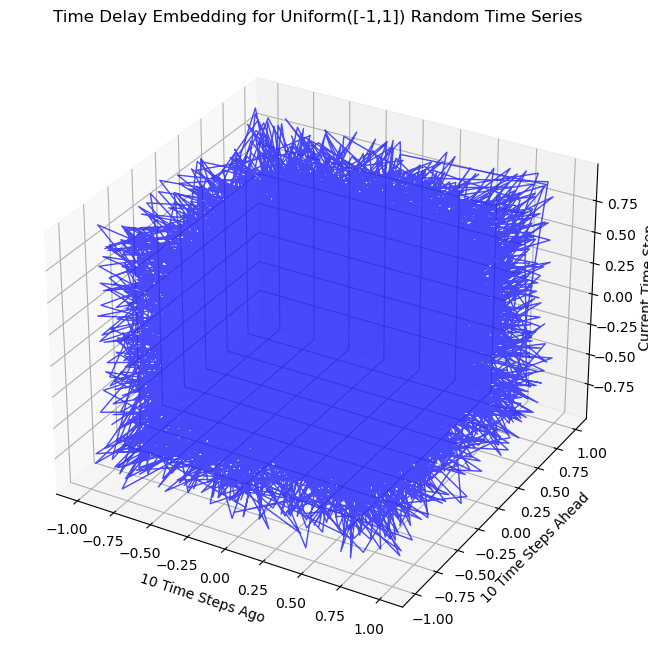

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a random time series
np.random.seed(42)
x = np.random.uniform(-1, 1, size=5000)

# Define the delay and embedding dimensions
delay = 10
embedding_dims = 3

# Create the time delay embedding
embedding = np.zeros((len(x) - delay * (embedding_dims - 1), embedding_dims))
for i in range(embedding_dims):
    embedding[:, i] = x[i * delay : i * delay + len(embedding)]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory as a line with constant color
ax.plot(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    color="blue",
    linewidth=1.0,
    alpha=0.7,
)

# Customize the plot
ax.set_title(f"Time Delay Embedding for Uniform([-1,1]) Random Time Series")
ax.set_xlabel(f"{delay} Time Steps Ago")
ax.set_ylabel(f"{delay} Time Steps Ahead")
ax.set_zlabel("Current Time Step")
plt.show()

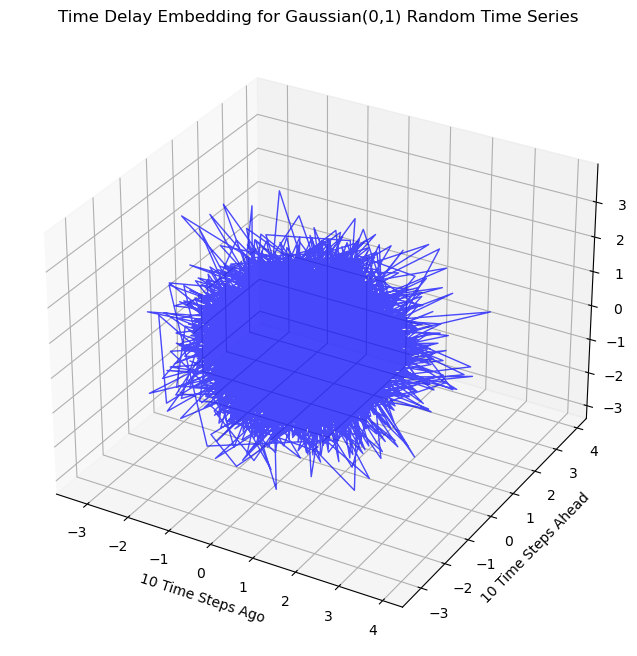

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a random time series
np.random.seed(42)
x = np.random.normal(0, 1, size=5000)

# Define the delay and embedding dimensions
delay = 10
embedding_dims = 3

# Create the time delay embedding
embedding = np.zeros((len(x) - delay * (embedding_dims - 1), embedding_dims))
for i in range(embedding_dims):
    embedding[:, i] = x[i * delay : i * delay + len(embedding)]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory as a line with constant color
ax.plot(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    color="blue",
    linewidth=1.0,
    alpha=0.7,
)

# Customize the plot
ax.set_title(f"Time Delay Embedding for Gaussian(0,1) Random Time Series")
ax.set_xlabel(f"{delay} Time Steps Ago")
ax.set_ylabel(f"{delay} Time Steps Ahead")
ax.set_zlabel("Current Time Step")
plt.show()

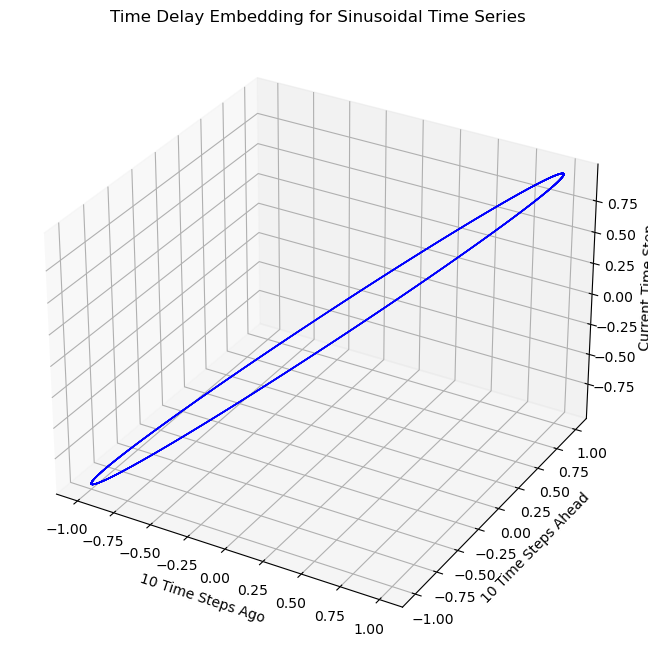

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate the sinusoidal time series
t = np.linspace(0, 10 * np.pi, num=5000)
x = np.sin(t)

# Define the delay and embedding dimensions
delay = 10
embedding_dims = 3

# Create the time delay embedding
embedding = np.zeros((len(x) - delay * (embedding_dims - 1), embedding_dims))
for i in range(embedding_dims):
    embedding[:, i] = x[i * delay : i * delay + len(embedding)]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory as a line that gets darker in color as time progresses
for i in range(len(embedding) - 1):
    ax.plot(
        [embedding[i, 0], embedding[i + 1, 0]],
        [embedding[i, 1], embedding[i + 1, 1]],
        [embedding[i, 2], embedding[i + 1, 2]],
        color="blue",
        linewidth=1.0,
        alpha=0.7,
    )

# Customize the plot
ax.set_title(f"Time Delay Embedding for Sinusoidal Time Series")
ax.set_xlabel(f"{delay} Time Steps Ago")
ax.set_ylabel(f"{delay} Time Steps Ahead")
ax.set_zlabel("Current Time Step")
plt.show()

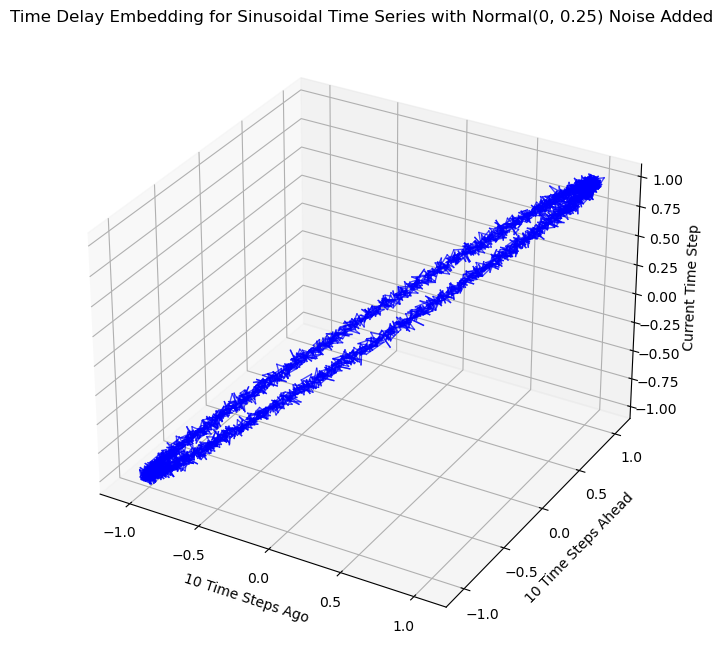

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate the sinusoidal time series
t = np.linspace(0, 10 * np.pi, num=5000)
x = np.cos(t) + np.random.normal(0, 0.025, size=5000)

# Define the delay and embedding dimensions
delay = 10
embedding_dims = 3

# Create the time delay embedding
embedding = np.zeros((len(x) - delay * (embedding_dims - 1), embedding_dims))
for i in range(embedding_dims):
    embedding[:, i] = x[i * delay : i * delay + len(embedding)]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory as a line that gets darker in color as time progresses
for i in range(len(embedding) - 1):
    ax.plot(
        [embedding[i, 0], embedding[i + 1, 0]],
        [embedding[i, 1], embedding[i + 1, 1]],
        [embedding[i, 2], embedding[i + 1, 2]],
        color="blue",
        linewidth=1.0,
        alpha=0.7,
    )

# Customize the plot
ax.set_title(
    f"Time Delay Embedding for Sinusoidal Time Series with Normal(0, 0.25) Noise Added"
)
ax.set_xlabel(f"{delay} Time Steps Ago")
ax.set_ylabel(f"{delay} Time Steps Ahead")
ax.set_zlabel("Current Time Step")
plt.show()

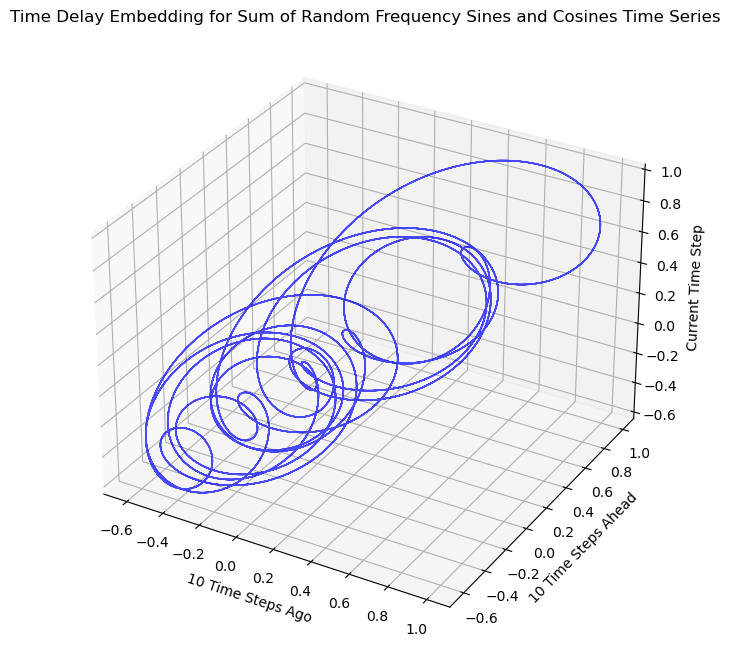

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Time series generation
timesteps = 5000
time = np.linspace(0, 10 * np.pi, timesteps)
frequencies = [1, 2, 4, 8, 16]  # Add or modify frequencies as needed

signal = np.zeros(timesteps)

for freq in frequencies:
    signal += np.sin(freq * time) + np.cos(freq * time)

# Normalize the signal to the range [-1, 1]
max_abs_value = np.max(np.abs(signal))
normalized_signal = signal / max_abs_value

# Time delay embedding
delay = 10
embedding = np.zeros((timesteps - 2 * delay, 3))

for i in range(timesteps - 2 * delay):
    embedding[i, 0] = normalized_signal[i]
    embedding[i, 1] = normalized_signal[i + delay]
    embedding[i, 2] = normalized_signal[i + 2 * delay]

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    color="blue",
    linewidth=1.0,
    alpha=0.7,
)
ax.set_title(
    f"Time Delay Embedding for Sum of Random Frequency Sines and Cosines Time Series"
)
ax.set_xlabel(f"{delay} Time Steps Ago")
ax.set_ylabel(f"{delay} Time Steps Ahead")
ax.set_zlabel("Current Time Step")
plt.show()